In [1]:
import pandas as pd
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pylab as plt
from time import time 
plt.style.use('default')

In [2]:
def window_calculations(df,ts,window_sizes = [3,5,7,15,30,60]):
    df_output = df.copy()
    for window in window_sizes:
        df_output.loc[:,f'mean_{window}'] = df[[ts]].rolling(window).mean()
        df_output.loc[:,f'std_{window}']  = df[[ts]].rolling(window).std()
        df_output.loc[:,f'skew_{window}'] = df[[ts]].rolling(window).skew()
        df_output.loc[:,f'max_{window}']  = df[[ts]].rolling(window).max()
        df_output.loc[:,f'min_{window}']  = df[[ts]].rolling(window).min()
        lm = LinearRegression()
        lm.fit(X =np.array(range(len(df_output))).reshape(-1,1),y = df['AEP_MW'])

        
    return(df_output)
def agg_from_date(dates):
    aggs = {}
    aggs['dayofweek'] = pd.Series(dates).dt.dayofweek.astype(float)
    aggs['quarter'] = pd.Series(dates).dt.quarter.astype(float)
    aggs['month'] = pd.Series(dates).dt.month.astype(float)
    aggs['year'] = pd.Series(dates).dt.year.astype(float)
    aggs['dayofyear'] = pd.Series(dates).dt.dayofyear.astype(float)
    aggs['dayofmonth'] = pd.Series(dates).dt.day.astype(float)
    aggs['weekofyear'] = pd.Series(dates).dt.isocalendar().week.astype(float)
    return(pd.DataFrame(aggs).set_index(dates))

# Single step prediction
Fits a model for one step prediction, to go forward in time the predictions are used to compute forward predictions

In [3]:
df = pd.read_csv('datasets/AEP_hourly.csv')
df['Datetime'] = pd.DatetimeIndex(df.Datetime)
df.set_index('Datetime',inplace=True)
df['Date'] = df.index.date
df = df.groupby('Date')[['AEP_MW']].sum()
df.index = pd.DatetimeIndex(df.index)
df.drop(index=df.index[-1],inplace=True)
df = df.merge(agg_from_date(df.index),left_index=True,right_index=True)
df.head()

,AEP_MW,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2004-10-01,328544.0,4.0,4.0,10.0,2004.0,275.0,1.0,40.0
2004-10-02,311997.0,5.0,4.0,10.0,2004.0,276.0,2.0,40.0
2004-10-03,293450.0,6.0,4.0,10.0,2004.0,277.0,3.0,40.0
2004-10-04,343417.0,0.0,4.0,10.0,2004.0,278.0,4.0,41.0
2004-10-05,346553.0,1.0,4.0,10.0,2004.0,279.0,5.0,41.0


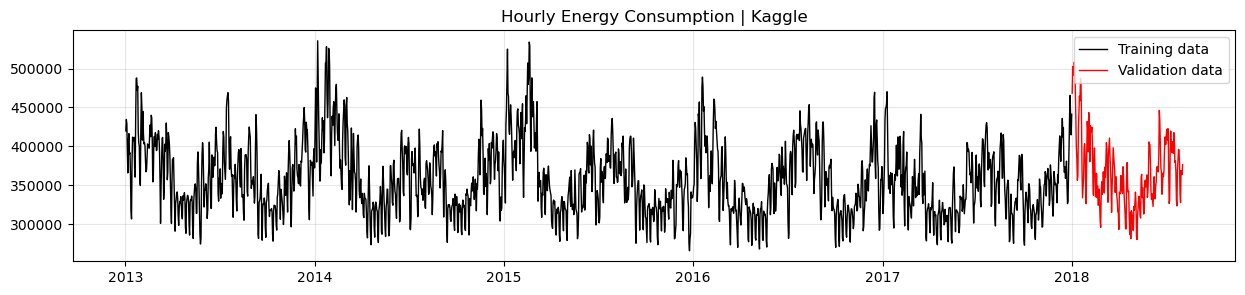

In [4]:
df_train = df[(df.index < pd.Timestamp(day=1,month=1,year=2018)) & (df.index > pd.Timestamp(day=1,month=1,year=2013)) ]
df_test  = df[df.index >= pd.Timestamp(day=1,month=1,year=2018)]

fig,ax = plt.subplots(figsize=(15,3))
plt.title('Hourly Energy Consumption | Kaggle')
plt.plot(df_train[['AEP_MW']],color='k',lw=1,label='Training data')
plt.plot(df_test[['AEP_MW']],color='r',lw=1,label='Validation data')
plt.legend(loc=1)
plt.grid(alpha=0.3)

In [5]:
df_train2 = window_calculations(df_train,'AEP_MW')
df_train2 = df_train2.iloc[59:,:]
df_train2 = pd.merge(df_train2,df_train2[['AEP_MW']].shift(-1).rename(columns={'AEP_MW':'Future_1'}),
         left_index=True,
         right_index=True).iloc[1:,:]

X = df_train2.iloc[:,:-1]
y = df_train2['Future_1']
y[df_train.index[-1]] = df_test.AEP_MW[0]

In [6]:
t1 = time()
model = XGBRegressor()
model.fit(X,y)
t2 = time()
fitting_time = t2 - t1

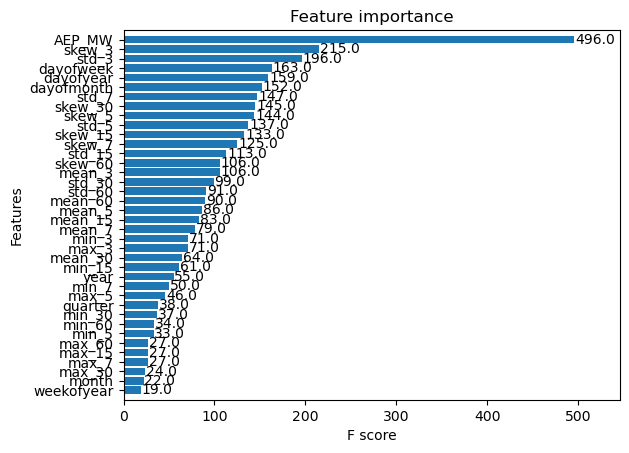

In [7]:
xgb.plot_importance(model,height=0.8,grid=False)

In [8]:
future_steps = len(df_test)
dates_predicted = df_test.iloc[:future_steps,:].index.copy()
df_predict = df.copy()
df_predict.loc[df_predict.index >= pd.Timestamp(day=1,month=1,year=2018),'AEP_MW'] = None

In [9]:
t1 = time()
for day in dates_predicted:
    last_observation = window_calculations(df_predict[df_predict.index < day],'AEP_MW').iloc[-1,:]
    df_predict.loc[day,'AEP_MW']= model.predict(np.array(last_observation).reshape(1,-1))[0]
t2 = time()
prediction_time = t2 - t1 

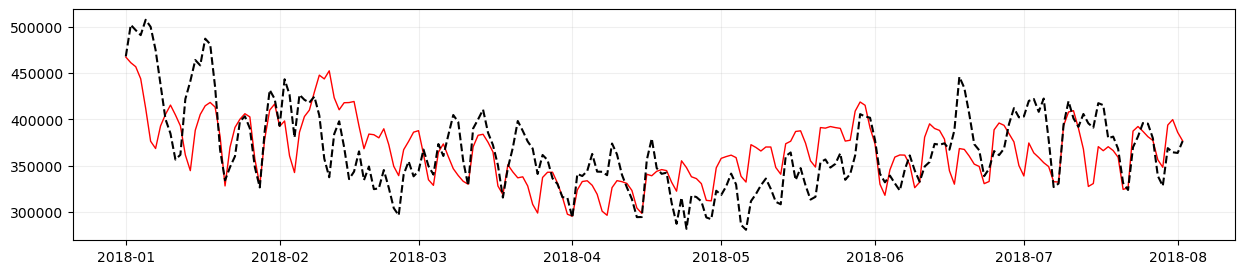

In [10]:
fig,ax = plt.subplots(figsize=(15,3))
plt.plot(dates_predicted, df_predict.loc[dates_predicted,'AEP_MW'],color='r',label='prediction',lw=1)

plt.plot(dates_predicted, df_test.loc[dates_predicted,'AEP_MW'],color='k',ls='--',label='real value')

plt.grid(alpha=0.2)

In [11]:
error = mean_squared_error(df_predict.loc[dates_predicted,'AEP_MW'],
                           df_test.loc[dates_predicted,'AEP_MW'],squared=False)

## Results

In [12]:
print(f'Fit time        = {fitting_time:.4f}s')
print(f'Prediction time = {prediction_time:.4f}s')
print(f'MSE             = {error:,.0f}')

Fit time        = 0.6250s
Prediction time = 7.4044s
MSE             = 38,347


# Two steps prediction
Fit 2 models for different lags and use them to predict forward

In [13]:
df = pd.read_csv('datasets/AEP_hourly.csv')
df['Datetime'] = pd.DatetimeIndex(df.Datetime)
df.set_index('Datetime',inplace=True)
df['Date'] = df.index.date
df = df.groupby('Date')[['AEP_MW']].sum()
df.index = pd.DatetimeIndex(df.index)
df.drop(index=df.index[-1],inplace=True)
df = df.merge(agg_from_date(df.index),left_index=True,right_index=True)
df.head()

,AEP_MW,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2004-10-01,328544.0,4.0,4.0,10.0,2004.0,275.0,1.0,40.0
2004-10-02,311997.0,5.0,4.0,10.0,2004.0,276.0,2.0,40.0
2004-10-03,293450.0,6.0,4.0,10.0,2004.0,277.0,3.0,40.0
2004-10-04,343417.0,0.0,4.0,10.0,2004.0,278.0,4.0,41.0
2004-10-05,346553.0,1.0,4.0,10.0,2004.0,279.0,5.0,41.0


In [14]:
df_train = df[(df.index < pd.Timestamp(day=1,month=1,year=2018)) & (df.index > pd.Timestamp(day=1,month=1,year=2013)) ]
df_test  = df[df.index >= pd.Timestamp(day=1,month=1,year=2018)]

In [15]:
df_train2 = window_calculations(df_train,'AEP_MW')
df_train2 = df_train2.iloc[59:,:]
df_train2['Future_1'] =df[['AEP_MW']].shift(-1).loc[df_train.index,:]
df_train2['Future_2'] =df[['AEP_MW']].shift(-2).loc[df_train.index,:]

X = df_train2.iloc[:,:-2]

y1 = df_train2['Future_1']
y2 = df_train2['Future_2']

In [16]:
t1 = time()
models = {}
models['lag1'] = XGBRegressor()
models['lag1'].fit(X,y1)

models['lag2'] = XGBRegressor()
models['lag2'].fit(X,y2)
t2 = time()

fitting_time = t2 - t1


In [17]:
future_steps = int(len(df_test))
dates_predicted = df_test.iloc[:future_steps,:].index.copy()
df_predict = df.copy()
df_predict.loc[df_predict.index >= pd.Timestamp(day=1,month=1,year=2018),'AEP_MW'] = None

In [18]:
t1 = time()
for i in range(0,future_steps,2):
    last_observation = window_calculations(df_predict[df_predict.index < dates_predicted[i]],'AEP_MW').iloc[-1,:]
    df_predict.loc[dates_predicted[i],'AEP_MW']= models['lag1'].predict(np.array(last_observation).reshape(1,-1))[0]
    df_predict.loc[dates_predicted[i+1],'AEP_MW']= models['lag2'].predict(np.array(last_observation).reshape(1,-1))[0]
t2 = time()
prediction_time = t2 - t1 

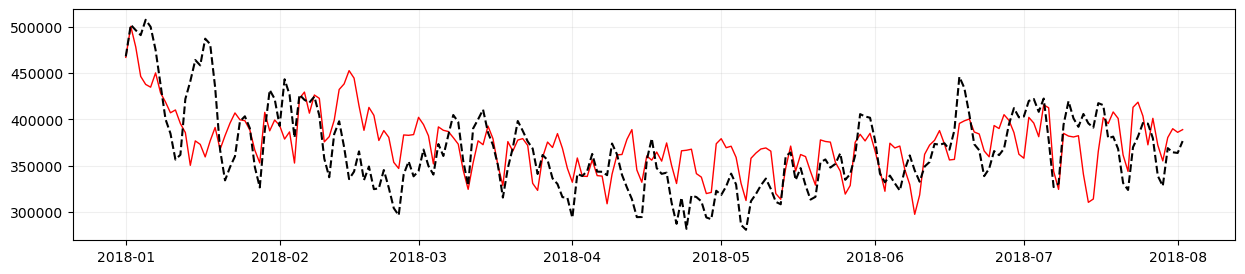

In [19]:
fig,ax = plt.subplots(figsize=(15,3))
plt.plot(dates_predicted, df_predict.loc[dates_predicted,'AEP_MW'],color='r',label='prediction',lw=1)

plt.plot(dates_predicted, df_test.loc[dates_predicted,'AEP_MW'],color='k',ls='--',label='real value')

plt.grid(alpha=0.2)

In [20]:
error = mean_squared_error(df_predict.loc[dates_predicted,'AEP_MW'],
                           df_test.loc[dates_predicted,'AEP_MW'],squared=False)

## Results

In [21]:
print(f'Fit time        = {fitting_time:.4f}s')
print(f'Prediction time = {prediction_time:.4f}s')
print(f'MSE             = {error:,.0f}')

Fit time        = 1.1119s
Prediction time = 3.8403s
MSE             = 37,657


# n steps predictions
Same as the former but the number steps defined by the user

In [22]:
n = 10

In [23]:
df = pd.read_csv('datasets/AEP_hourly.csv')
df['Datetime'] = pd.DatetimeIndex(df.Datetime)
df.set_index('Datetime',inplace=True)
df['Date'] = df.index.date
df = df.groupby('Date')[['AEP_MW']].sum()
df.index = pd.DatetimeIndex(df.index)
df.drop(index=df.index[-1],inplace=True)
df = df.merge(agg_from_date(df.index),left_index=True,right_index=True)
df.head()

,AEP_MW,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2004-10-01,328544.0,4.0,4.0,10.0,2004.0,275.0,1.0,40.0
2004-10-02,311997.0,5.0,4.0,10.0,2004.0,276.0,2.0,40.0
2004-10-03,293450.0,6.0,4.0,10.0,2004.0,277.0,3.0,40.0
2004-10-04,343417.0,0.0,4.0,10.0,2004.0,278.0,4.0,41.0
2004-10-05,346553.0,1.0,4.0,10.0,2004.0,279.0,5.0,41.0


In [24]:
df_train = df[(df.index < pd.Timestamp(day=1,month=1,year=2018)) & (df.index > pd.Timestamp(day=1,month=1,year=2013)) ]
df_test  = df[df.index >= pd.Timestamp(day=1,month=1,year=2018)]

In [25]:
df_train2 = window_calculations(df_train,'AEP_MW')
df_train2 = df_train2.iloc[59:,:]

yy = {}
for i in range(1,n+1):
    df_train2[f'Future_{i}'] =df[['AEP_MW']].shift(-i).loc[df_train.index,:]
    yy[f'lag{i}'] = df_train2[f'Future_{i}']
    
X = df_train2.iloc[:,:-n]

In [26]:
t1 = time()
models = {}
for i in range(1,n+1):
    models[f'lag{i}'] = XGBRegressor()
    models[f'lag{i}'].fit(X,yy[f'lag{i}'])
t2 = time()

fitting_time = t2 - t1


In [27]:
future_steps = int(len(df_test)/n)*n
dates_predicted = df_test.iloc[:future_steps,:].index.copy()
df_predict = df.copy()
df_predict.loc[df_predict.index >= pd.Timestamp(day=1,month=1,year=2018),'AEP_MW'] = None

In [28]:
t1 = time()
for i in range(0,future_steps,n):
    last_observation = window_calculations(df_predict[df_predict.index < dates_predicted[i]],'AEP_MW').iloc[-1,:]

    for k in range(n):
        df_predict.loc[dates_predicted[i+k],'AEP_MW']= models[f'lag{k+1}'].predict(np.array(last_observation).reshape(1,-1))[0]
t2 = time()
prediction_time = t2 - t1 

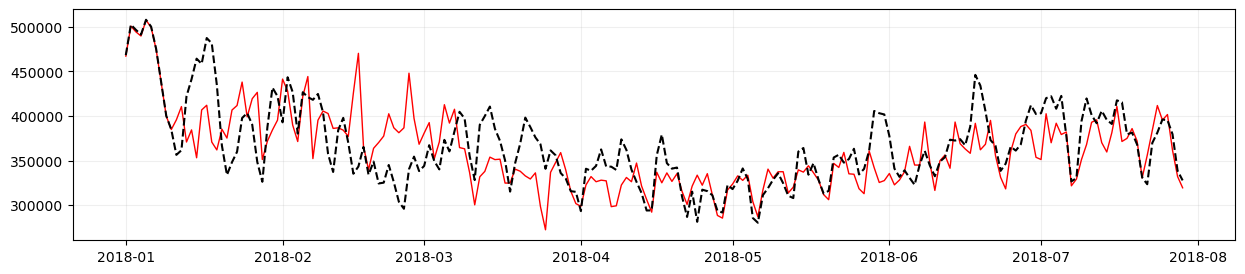

In [29]:
fig,ax = plt.subplots(figsize=(15,3))
plt.plot(dates_predicted, df_predict.loc[dates_predicted,'AEP_MW'],color='r',label='prediction',lw=1)

plt.plot(dates_predicted, df_test.loc[dates_predicted,'AEP_MW'],color='k',ls='--',label='real value')

plt.grid(alpha=0.2)

In [30]:
error = mean_squared_error(df_predict.loc[dates_predicted,'AEP_MW'],
                           df_test.loc[dates_predicted,'AEP_MW'],squared=False)

## Results 

In [31]:
print(f'Fit time        = {fitting_time:.4f}s')
print(f'Prediction time = {prediction_time:.4f}s')
print(f'MSE             = {error:,.0f}')

Fit time        = 4.5370s
Prediction time = 1.0452s
MSE             = 36,067


# Model only using the date as a input of the model

In [32]:
df = pd.read_csv('datasets/AEP_hourly.csv')
df['Datetime'] = pd.DatetimeIndex(df.Datetime)
df.set_index('Datetime',inplace=True)
df['Date'] = df.index.date
df = df.groupby('Date')[['AEP_MW']].sum()
df.index = pd.DatetimeIndex(df.index)
df.drop(index=df.index[-1],inplace=True)
df = df.merge(agg_from_date(df.index),left_index=True,right_index=True)
df.head()
df_train = df[(df.index < pd.Timestamp(day=1,month=1,year=2018)) & (df.index > pd.Timestamp(day=1,month=1,year=2013)) ]
df_test  = df[df.index >= pd.Timestamp(day=1,month=1,year=2018)]


X = df_train.iloc[:,1:]
y = df_train['AEP_MW']

In [33]:
t1 = time()
model = XGBRegressor()
model.fit(X,y)
t2 = time()
fitting_time = t2-t1

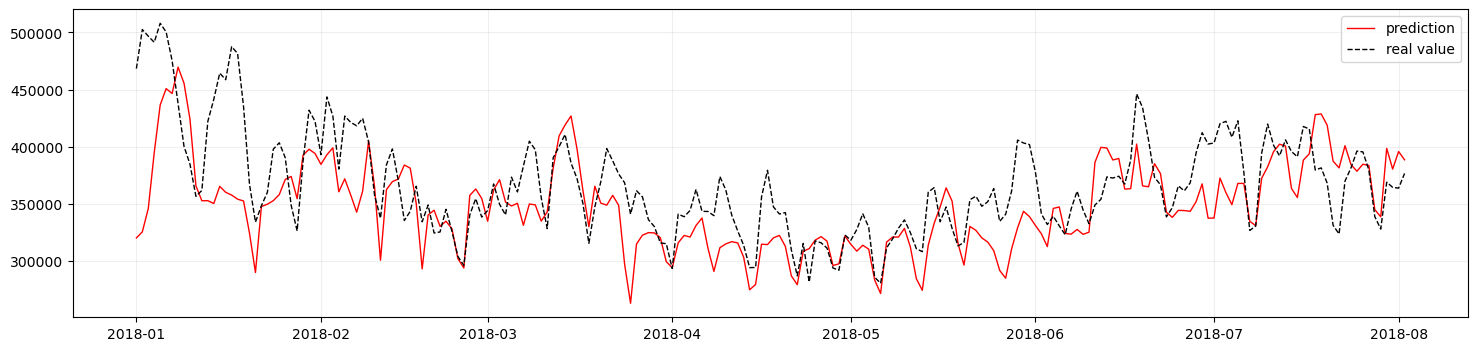

In [34]:
X_test = df_test.iloc[:,1:]
y_test = df_test['AEP_MW']
fig,ax = plt.subplots(figsize=(18,4))
t1 = time()
X_pred = model.predict(X_test)
t2 = time()
prediction_time = t2 - t1
plt.plot(y_test.index,X_pred,color='r',label='prediction',lw=1)
plt.plot(y_test,color='k',label='real value',ls='--',lw=1)
plt.grid(alpha=0.2)
plt.legend()

In [35]:
error = mean_squared_error(model.predict(X_test),y_test,squared=False)

## Results

In [36]:
print(f'Fit time        = {fitting_time:.4f}s')
print(f'Prediction time = {prediction_time:.4f}s')
print(f'MSE             = {error:,.0f}')

Fit time        = 0.2593s
Prediction time = 0.0020s
MSE             = 41,847


# Model only using the date as a input of the model GridSearchCV

In [37]:
df = pd.read_csv('datasets/AEP_hourly.csv')
df['Datetime'] = pd.DatetimeIndex(df.Datetime)
df.set_index('Datetime',inplace=True)
df['Date'] = df.index.date
df = df.groupby('Date')[['AEP_MW']].sum()
df.index = pd.DatetimeIndex(df.index)
df.drop(index=df.index[-1],inplace=True)
df = df.merge(agg_from_date(df.index),left_index=True,right_index=True)
df.head()

,AEP_MW,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2004-10-01,328544.0,4.0,4.0,10.0,2004.0,275.0,1.0,40.0
2004-10-02,311997.0,5.0,4.0,10.0,2004.0,276.0,2.0,40.0
2004-10-03,293450.0,6.0,4.0,10.0,2004.0,277.0,3.0,40.0
2004-10-04,343417.0,0.0,4.0,10.0,2004.0,278.0,4.0,41.0
2004-10-05,346553.0,1.0,4.0,10.0,2004.0,279.0,5.0,41.0


In [38]:
df_train = df[(df.index < pd.Timestamp(day=1,month=1,year=2018)) & (df.index > pd.Timestamp(day=1,month=1,year=2013)) ]
df_test  = df[df.index >= pd.Timestamp(day=1,month=1,year=2018)]

In [39]:
X = df_train.iloc[:,1:]
y = df_train['AEP_MW']

In [40]:
param_grid = {'learning_rate':np.linspace(0.01,0.3,5),
              'max_depth':[5,6,7,8]}

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
t1 = time()
model = GridSearchCV(cv=5,estimator = XGBRegressor(),param_grid=param_grid)
model.fit(X,y)
print(model.best_estimator_)
t2 = time()
fitting_time = t2 - t1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.08249999999999999,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=128,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


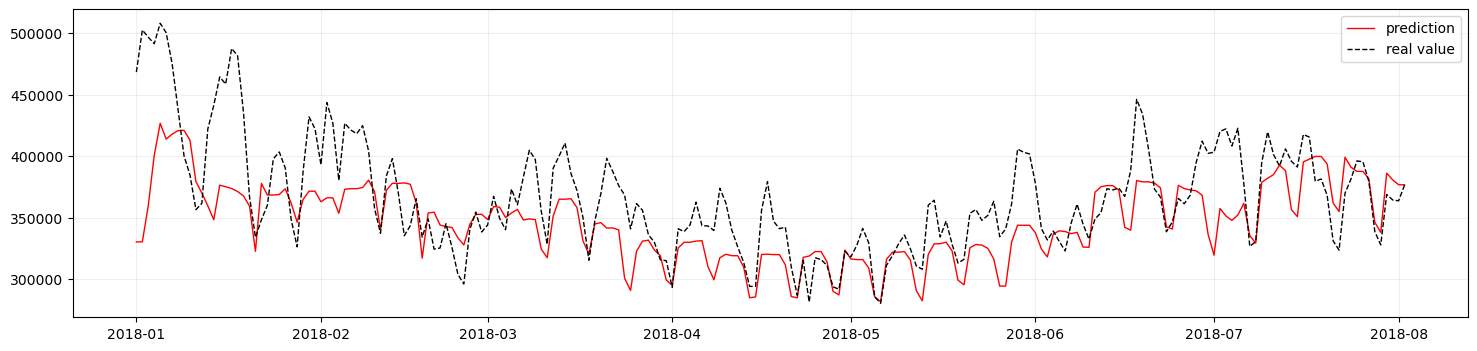

In [43]:
X_test = df_test.iloc[:,1:]
y_test = df_test['AEP_MW']
fig,ax = plt.subplots(figsize=(18,4))
t1 = time()
X_pred = model.predict(X_test)
t2 = time()
prediction_time = t2 - t1
plt.plot(y_test.index,X_pred,color='r',label='prediction',lw=1)
plt.plot(y_test,color='k',label='real value',ls='--',lw=1)
plt.grid(alpha=0.2)
plt.legend()

In [44]:
error = mean_squared_error(model.predict(X_test),y_test,squared=False)

## Results

In [45]:
print(f'Fit time        = {fitting_time:.4f}s')
print(f'Prediction time = {prediction_time:.4f}s')
print(f'MSE             = {error:,.0f}')

Fit time        = 26.9541s
Prediction time = 0.0017s
MSE             = 39,164


In [46]:
X.shape

(1825, 7)

# Use lags as inputs of the model

In [47]:
df = pd.read_csv('datasets/AEP_hourly.csv')
df['Datetime'] = pd.DatetimeIndex(df.Datetime)
df.set_index('Datetime',inplace=True)
df['Date'] = df.index.date
df = df.groupby('Date')[['AEP_MW']].sum()
df.index = pd.DatetimeIndex(df.index)
df.drop(index=df.index[-1],inplace=True)
df = df.merge(agg_from_date(df.index),left_index=True,right_index=True)
df.head()

,AEP_MW,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2004-10-01,328544.0,4.0,4.0,10.0,2004.0,275.0,1.0,40.0
2004-10-02,311997.0,5.0,4.0,10.0,2004.0,276.0,2.0,40.0
2004-10-03,293450.0,6.0,4.0,10.0,2004.0,277.0,3.0,40.0
2004-10-04,343417.0,0.0,4.0,10.0,2004.0,278.0,4.0,41.0
2004-10-05,346553.0,1.0,4.0,10.0,2004.0,279.0,5.0,41.0


In [48]:
df_train = df[(df.index < pd.Timestamp(day=1,month=1,year=2018)) & (df.index > pd.Timestamp(day=1,month=1,year=2013)) ]
df_test  = df[df.index >= pd.Timestamp(day=1,month=1,year=2018)]

In [49]:
lags = 5 
for j in range(1,lags):
    df_train.loc[:,f'AEP_MW_lag_{j}'] = df_train.loc[:,'AEP_MW'].shift(j).copy()
df_train = df_train.iloc[lags-1:,:]

/home/alejandro/miniconda3/envs/boost21/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [50]:
X = df_train.iloc[:,1:]
y = df_train['AEP_MW']

In [51]:
t1 = time()
model = XGBRegressor()
model.fit(X,y)
t2 = time()
fitting_time = t2 - t1

In [52]:
for j in range(1,lags):
    df.loc[:,f'AEP_MW_lag_{j}'] = df.loc[:,'AEP_MW'].shift(j).copy()
df_pred = df.iloc[lags-1:,:]

In [53]:
df_pred.loc[df_test.index[0]:,['AEP_MW']] = None
df_pred.loc[df_test.index[1]:,[f'AEP_MW_lag_{i}' for i in range(1,lags)]] = None

/home/alejandro/miniconda3/envs/boost21/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [54]:
t1 = time()
df_pred.loc[df_test.index[0],'AEP_MW'] = model.predict(np.array(df_pred.loc[df_test.index[0],:].iloc[1:]).reshape(1,-1))[0]

for j in range(len(df_test.index[1:])):
    df_pred.loc[df_test.index[j+1],f'AEP_MW_lag_{1}'] = df_pred.loc[df_test.index[j],'AEP_MW']
    for i in range(2,lags):
        df_pred.loc[df_test.index[j+1],f'AEP_MW_lag_{i}'] = df_pred.loc[df_test.index[j],f'AEP_MW_lag_{i-1}']
    df_pred.loc[df_test.index[j+1],'AEP_MW'] = model.predict(np.array(df_pred.loc[df_test.index[j+1],:].iloc[1:]).reshape(1,-1))[0]
t2 = time()
prediction_time = t2 - t1

/home/alejandro/miniconda3/envs/boost21/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/alejandro/miniconda3/envs/boost21/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


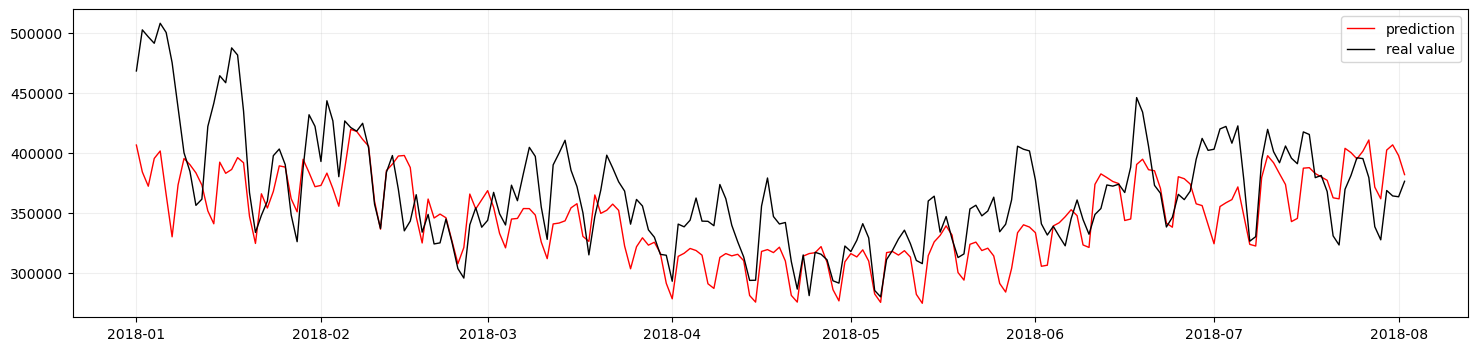

In [55]:
fig,ax = plt.subplots(figsize=(18,4))
plt.plot(df_pred.loc[df_test.index,'AEP_MW'],color='r',label='prediction',lw=1)
plt.plot(df_test.loc[df_test.index,'AEP_MW'],color='k',label='real value',lw=1)
plt.grid(alpha=0.2)
plt.legend()

In [56]:
error = mean_squared_error(df_pred.loc[df_test.index,'AEP_MW'],df_test.AEP_MW,squared=False)

## Results

In [57]:
print(f'Fit time        = {fitting_time:.4f}s')
print(f'Prediction time = {prediction_time:.4f}s')
print(f'MSE             = {error:,.0f}')

Fit time        = 0.6048s
Prediction time = 0.4778s
MSE             = 39,168


# Using MultiOutputRegressor for n steps to the future

In [58]:
from sklearn.multioutput import MultiOutputRegressor

In [59]:
df = pd.read_csv('datasets/AEP_hourly.csv')
df['Datetime'] = pd.DatetimeIndex(df.Datetime)
df.set_index('Datetime',inplace=True)
df['Date'] = df.index.date
df = df.groupby('Date')[['AEP_MW']].sum()
df.index = pd.DatetimeIndex(df.index)
df.drop(index=df.index[-1],inplace=True)
df = df.merge(agg_from_date(df.index),left_index=True,right_index=True)
df.head()

,AEP_MW,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2004-10-01,328544.0,4.0,4.0,10.0,2004.0,275.0,1.0,40.0
2004-10-02,311997.0,5.0,4.0,10.0,2004.0,276.0,2.0,40.0
2004-10-03,293450.0,6.0,4.0,10.0,2004.0,277.0,3.0,40.0
2004-10-04,343417.0,0.0,4.0,10.0,2004.0,278.0,4.0,41.0
2004-10-05,346553.0,1.0,4.0,10.0,2004.0,279.0,5.0,41.0
